# Understanding CNNs - VGG-16

We're going to use convolutional neural networks (CNNs) to allow our computer to see - something that is only possible thanks to deep learning. A shout out to Kadenze and platform ai for providing the resources for this tutorial

## Comparison of AlexNet and VGG-16
<img src="contents/comparison-alex-vgg16.png">

## Why Deeper Works - One Reason
The deeper you go, the more unrelated parts are gradually removed and the discriminative parts gradually stand out
<img src="contents/why-deeper-works.png">

Images taken from
https://icmlviz.github.io/assets/papers/4.pdf

## Introduction to this week's task: 'Dogs vs Cats'

We're going to try to create a model to enter the [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats) competition at Kaggle. There are 25,000 labelled dog and cat photos available for training, and 12,500 in the test set that we have to try to label for this competition. According to the Kaggle web-site, when this competition was launched (end of 2013): *"**State of the art**: The current literature suggests machine classifiers can score above 80% accuracy on this task"*. So if we can beat 80%, then we will be at the cutting edge as at 2013!

## Basic setup

There isn't too much to do to get started - just a few simple configuration steps.

First download the Dataset from https://goo.gl/fr96Xj and place it in a folder called `data`, unzipped, of course

This imports numpy, scipy and matplotlib with the common namespaces, and shows plots in the web page itself - we always wants to use this when using jupyter notebook:

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Our first step is simply to use a model that has been fully created for us, which can recognise a wide variety (1,000 categories) of images. We will use 'VGG', which won the 2014 Imagenet competition, and is a very simple model to create and understand. The VGG Imagenet team created both a larger, slower, slightly more accurate model (*VGG  19*) and a smaller, faster model (*VGG 16*). We will be using VGG 16 since the much slower performance of VGG19 is generally not worth the very minor improvement in accuracy.


## Use our Vgg16 class to finetune a Dogs vs Cats model

To change our model so that it outputs "cat" vs "dog", instead of one of 1,000 very specific categories, we need to use a process called "finetuning". Finetuning looks from the outside to be identical to normal machine learning training - we provide a training set with data and labels to learn from, and a validation set to test against. The model learns a set of parameters based on the data provided.

However, the difference is that we start with a model that is already trained to solve a similar problem. The idea is that many of the parameters should be very similar, or the same, between the existing model, and the model we wish to create. Therefore, we only select a subset of parameters to train, and leave the rest untouched. This happens automatically when we call *fit()* after calling *finetune()*.

We create our batches just like before, and making the validation set available as well. A 'batch' (or *mini-batch* as it is commonly known) is simply a subset of the training data - we use a subset at a time when training or predicting, in order to speed up training, and to avoid running out of memory.

A few basic libraries that we'll need for the initial exercises:

**NOTE**: It is important to make sure that the "image_dim_ordering" is set to "th" in your `keras.json` file in the `.keras` folder in your home folder (appears after you run keras at least once. If it doesn't create the file).

In [2]:
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

import os,json
from numpy.random import random, permutation
import tensorflow as tf

from keras.preprocessing import image
from keras.optimizers import SGD, RMSprop, Adam

Using TensorFlow backend.


When trying the code out, use the sample folder. When training for the full dataset, comment the second and uncomment the first line

Define path to data: (It's a good idea to put it in a subdirectory of your notebooks folder, and then exclude that directory from git control by adding it to .gitignore.)

In [4]:
# path = "data/dogscats/"
path = "data/dogscats/sample/"

Let's import the mappings from VGG ids to imagenet category ids and descriptions, for display purposes later.

In [5]:
FILES_PATH = 'http://www.platform.ai/models/'; CLASS_FILE='imagenet_class_index.json'
# Keras' get_file() is a handy function that downloads files, and caches them for re-use later
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')
with open(fpath) as f: class_dict = json.load(f)
# Convert dictionary with string indexes into an array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

Here's a few examples of the categories we just imported:

In [6]:
classes[:5]

['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead']

## Model creation

Creating the model involves creating the model architecture, and then loading the model weights into that architecture. We will start by defining the basic pieces of the VGG architecture.

VGG has just one type of convolutional block, and one type of fully connected ('dense') block. Here's the convolutional block definition:

In [7]:
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

...and here's the fully-connected definition.

In [8]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

When the VGG model was trained in 2014, the creators subtracted the average of each of the three (R,G,B) channels first, so that the data for each channel had a mean of zero. Furthermore, their software that expected the channels to be in B,G,R order, whereas Python by default uses R,G,B. We need to preprocess our data to make these two changes, so that it is compatible with the VGG model:

In [9]:
# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]    # reverse axis bgr->rgb

Now we're ready to define the VGG model architecture - look at how simple it is, now that we have the basic blocks defined!

The architecture, as shown above, is
<img src="contents/vgg16.png">

In [10]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

We'll learn about what these different blocks do later in the course. For now, it's enough to know that:

- Convolution layers are for finding patterns in images
- Dense (fully connected) layers are for combining patterns across an image

Now that we've defined the architecture, we can create the model like any python object:

In [11]:
model = VGG_16()

As well as the architecture, we need the weights that the VGG creators trained. The weights are the part of the model that is learnt from the data, whereas the architecture is pre-defined based on the nature of the problem. 

Downloading pre-trained weights is much preferred to training the model ourselves, since otherwise we would have to download the entire Imagenet archive, and train the model for many days! It's very helpful when researchers release their weights, as they did here.

In [12]:
fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
with tf.device('/cpu:0'):
    model.load_weights(fpath)

## Getting imagenet predictions

The setup of the imagenet model is now complete, so all we have to do is grab a batch of images and call *predict()* on them.

In [13]:
batch_size = 4

Keras provides functionality to create batches of data from directories containing images; all we have to do is to define the size to resize the images to, what type of labels to create, whether to randomly shuffle the images, and how many images to include in each batch. We use this little wrapper to define some helpful defaults appropriate for imagenet data:

From here we can use exactly the same steps as before to look at predictions from the model. But before that, let's define a few helper functions

In [14]:
def get_batches(path, gen=image.ImageDataGenerator(), shuffle=True, batch_size=8, class_mode='categorical'):
        return gen.flow_from_directory(path, target_size=(224,224),
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        if titles is not None:
            sp.set_title(titles[i], fontsize=18)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

Found 16 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


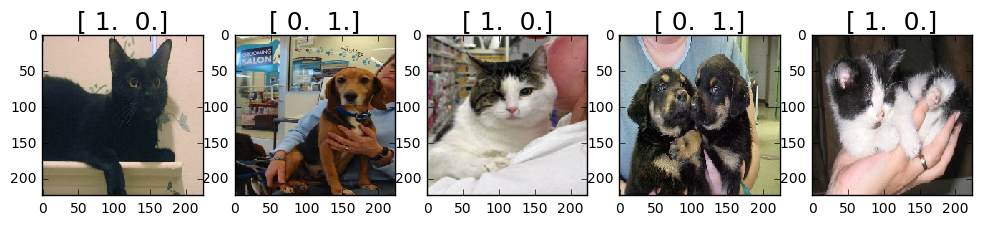

In [15]:
batches = get_batches(path+'train', batch_size=5)
val_batches = get_batches(path+'valid', batch_size=batch_size)
imgs,labels = next(batches)

# This shows the 'ground truth'
plots(imgs, titles=labels)

The VGG model returns 1,000 probabilities for each image, representing the probability that the model assigns to each possible imagenet category for each image. By finding the index with the largest probability (with *np.argmax()*) we can find the predicted label.

In [16]:
def pred_batch(imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)

    print('Shape: {}'.format(preds.shape))
    print('First 5 classes: {}'.format(classes[:5]))
    print('First 5 probabilities: {}\n'.format(preds[0, :5]))
    print('Predictions prob/class: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))

In [17]:
pred_batch(imgs)

Shape: (5, 1000)
First 5 classes: ['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead']
First 5 probabilities: [  1.59354109e-04   6.46181070e-05   1.24945524e-04   3.87055072e-04
   1.87049562e-03]

Predictions prob/class: 
  0.0889/Egyptian_cat
  0.4083/miniature_pinscher
  0.1281/Pekinese
  0.1111/toy_terrier
  0.2508/marmoset


## Transfer Learning

Here, we attempt to solve the Dogs vs Cats Kaggle problem using transfer learning from our pre trained VGG-16 model, by replacing and learning the last layer alone

In [19]:
model.pop()
for layer in model.layers: layer.trainable=False
model.add(Dense(batches.nb_class, activation='softmax'))
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
batches = get_batches(path+'train', batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size)
print((batches))
model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=5, validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Found 16 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Epoch 1/5
16/16 [==============================] - 8s - loss: 1.5623 - acc: 0.6250 - val_loss: 1.0083 - val_acc: 0.5000
Epoch 2/5
16/16 [==============================] - 5s - loss: 1.2245 - acc: 0.4375 - val_loss: 0.2712 - val_acc: 0.8750
Epoch 3/5
16/16 [==============================] - 5s - loss: 0.3008 - acc: 0.8750 - val_loss: 0.0784 - val_acc: 1.0000
Epoch 4/5
16/16 [==============================] - 5s - loss: 0.2186 - acc: 0.9375 - val_loss: 0.0436 - val_acc: 1.0000
Epoch 5/5
16/16 [==============================] - 5s - loss: 0.1444 - acc: 0.9375 - val_loss: 0.0445 - val_acc: 1.0000


## Final Task

Now go on, train on your GPU, and train on the entire dataset rather than just the sample dataset